# Deep learning course project

# SRGAN: Super Resolution Generative Adversarial Networks

# Mayryam Bandali

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#@title Import Dependencies
import  os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
from PIL import Image
from skimage.transform import resize

from keras.models import Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, Input, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices------------- 0


IndexError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/My\ Drive/GAN/DIV2K_train_HR112.zip /home/  
!mkdir /home/train_data

mkdir: cannot create directory ‘/home/train_data’: File exists


In [ ]:
!unzip /home/DIV2K_train_HR112.zip -d /home/train_data

Archive:  /home/DIV2K_train_HR112.zip
replace /home/train_data/DIV2K_train_HR112/0614.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [ ]:
#@title Resizing the image

import cv2
import os
import glob
img_dir = "/home/train_data/DIV2K_train_HR112" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*.png')
files = glob.glob(data_path)

img_list, img_low_list = [], []
for i in files:
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,256,256)
    img_list.append(img_crop)
    img_low_list.append(resize(img_crop,(64,64)))

high_reso_imgs = img_list
low_reso_imgs = img_low_list    
  

In [ ]:
high_reso_imgs=np.array(high_reso_imgs)
low_reso_imgs=np.array(low_reso_imgs)
low_reso_imgs.shape

(112, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


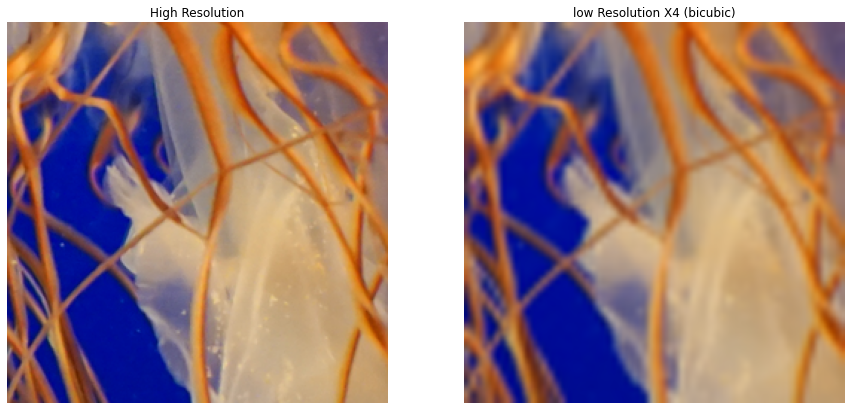

In [ ]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[100])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[100],(256,256),
                      interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')

In [ ]:
#@title Creating the model
class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 64,lr_width = 64,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = np.asarray(high_reso_imgs).shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            
            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)
            
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            
            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            #We should use yield when we want to iterate over a sequence but don't want to store the entire sequence in memory. 
            #yield is used in Python generators. A generator function is defined like a normal function, but whenever it needs to generate 
            #a value, it does so with the yield keyword rather than return.
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):
        vgg = VGG19(weights = "imagenet")
#         vgg.summary()
        vgg.outputs = [vgg.layers[9].output]
        img = Input(shape = self.shape_high_reso)
        img_features = vgg(img)
        vgg_model = Model(img, img_features)
        for layer in vgg_model.layers:#****************************************************************************************
          layer.trainable = False
        vgg_model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),
                         metrics =['acc'])
        return vgg_model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.nn.depth_to_space(x, scale))
  
    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)
        
        output_residual = BatchNormalization(momentum=0.8)(output_residual)
        
        output_residual = Add()([output_residual,first_layer])
               
        upsample_layer = self.Upsample_Block(output_residual)
        
        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)
            
        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        #for i in range(n_blocks):
        #discriminator_blocks = self.disc_block(discriminator_blocks, n_filters = (i+1)*2*n_filters)
        discriminator_blocks = self.disc_block(discriminator_blocks, n_filters = 128)
        discriminator_blocks = self.disc_block(discriminator_blocks, n_filters = 256)
        discriminator_blocks = self.disc_block(discriminator_blocks, n_filters = 512)
        
        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)#generate fake high resolution images using the generator network
        generated_features = self.vgg(generated_high_reso)#extract the feautures of the fake generated images using the VGG19 network
        generator_valid = self.discriminator(generated_high_reso)#pass the fake images to the discriminator network
                                                                 #Use the discriminator network to get the probabilities of 
                                                                 #the generated high resolution fake images.

        #Finally, create a Keras model, which will be our adversarial model
        gan_model = Model(inputs = [gen_input, dis_input], 
                          outputs = [generator_valid, generated_features])#Adversarial model
        
        for l in gan_model.layers[-1].layers[-1].layers:
          l.trainable=False #we are making the discriminator network non-trainable because we don't want to train the 
                            #discriminator network while we train the generator network
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        
        return gan_model

        #We have now successfully implemented the networks. Next, we train the network on the dataset.



    def train(self, epochs, save_interval = 100, batch_size = 16):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)#train_on_batch:Runs a single gradient update on a single batch of data.
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            if epo % save_interval == 0:
              self.save_GAN_Model(epo)
              self.plotLosses(dlosses,glosses,epo)
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])


In [ ]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,np.asarray(low_reso_imgs).shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
        
        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 -1 )
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
        
    plt.savefig('predicted.png')
        

In [ ]:
model_srgan = SRGAN()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  11252995    input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    5219137     model_3[1][0]                    
__________________________________________________________________________________________________
model_1 (Model)

In [ ]:
model_srgan.generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, 64, 64)   262144      conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 64, 64, 64)   36928       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
model_srgan.discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     7385

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
#os.chdir('/content')
#!mkdir training_process
#os.chdir('./training_process')

In [ ]:
#shutil.move('/content/srgan_weights_epoch_240.h5', os.getcwd())

In [ ]:
#os.chdir('/content/drive/My Drive/GAN/models/train-500epoch-saturday')
#model_srgan.srgan.load_weights('srgan_weights_epoch_360.h5')

In [ ]:
os.chdir('/content/drive/My Drive/GAN/models/train-500epoch-new')

In [ ]:
model_srgan.train(100, save_interval=50 ,batch_size=16)

--------------- Epoch 1 ---------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7 [00:00<?, ?it/s]

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

In [ ]:
import cv2
import os
import glob
img_dir = "/home/train_data/DIV2K_train_HR" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*.png')
files = glob.glob(data_path)

img_list, img_low_list = [], []
for i in files:
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,256,256)
    img_list.append(img_crop)
    img_low_list.append(resize(img_crop,(64,64)))

high_reso_imgs = img_list[len(img_list)-100:]
low_reso_imgs = img_low_list[len(img_list)-100:] 

In [ ]:
#!pip uninstall h5py
#!pip install h5py==2.10.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


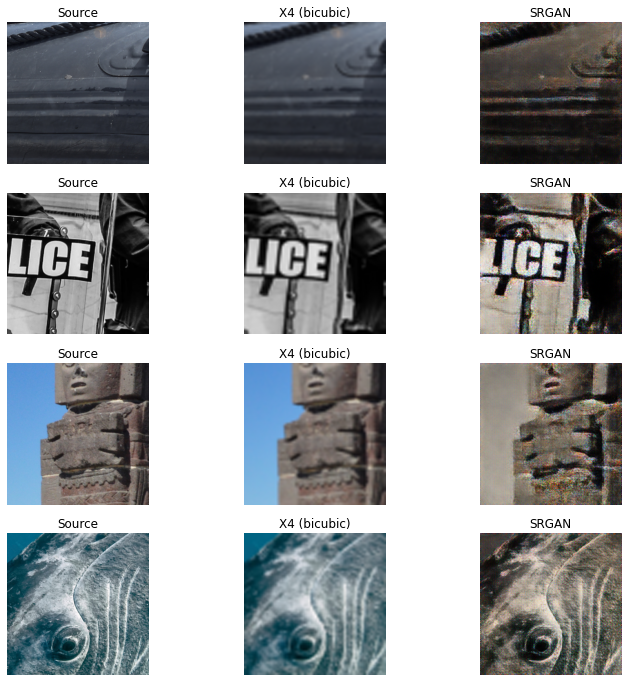

In [ ]:
# Load pretrained model
model_srgan.srgan.load_weights('srgan_weights_epoch_350.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_100.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_150.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_200.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_250.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_300.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_350.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_400.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_450.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_500.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
os.chdir('/content/drive/My Drive/GAN/models/train-500epoch-sunday')
model_srgan.srgan.load_weights('srgan_weights_epoch_500.h5')

In [ ]:
os.chdir('/content/drive/My Drive/GAN/models/train-500epoch-new')

In [ ]:
model_srgan.train(500, save_interval=50 ,batch_size=16)

In [ ]:
os.chdir('/content/drive/My Drive/GAN/models/train-500epoch-new')

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_50.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_100.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_150.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_200.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_250.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_300.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_350.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_400.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_450.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)

In [ ]:
model_srgan.srgan.load_weights('srgan_weights_epoch_500.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)